In [1]:
import os


from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow_docs import plots as tfplots
from tensorflow.keras import layers, models

In [2]:
np.random.seed(2021)
tf.random.set_seed(2021)

In [3]:
def display_table_dict(data, direction='horizontal'):
    html = '<table>'

    if direction == 'horizontal':
        html += '<tr>'
        for index, key in enumerate(data.keys()):
            if index == 0:
                html += '<th>{}</th>'.format(key)
            else:
                html += '<td>{}</td>'.format(key)
        
        html += '</tr><tr>'
        for index, value in enumerate(data.values()):
            if index == 0:
                html += '<th>{}</th>'.format(value)
            else:
                html += '<td>{}</td>'.format(value)

        html += '</tr>'
    
    elif direction == 'vertical':
        pass

    html += '</html>'
    display(HTML(html))


def plot_confusion_matrix(y_true, y_predicted, labels=[], ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 12))

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_true.argmax(axis=1), y_predicted.argmax(axis=1)),
        display_labels=labels
    ).plot(include_values=True, cmap=plt.cm.Blues, ax=ax)


dataset_folder = os.path.join(os.getcwd(), 'dataset')
def load_dataset(filename):
    return os.path.join(dataset_folder, filename)

In [4]:
X = np.load(load_dataset('X_finetune.npy'))
y = np.load(load_dataset('y_finetune.npy'))

X_test = np.load(load_dataset('X_test.npy'))
y_test = np.load(load_dataset('y_test.npy'))

print('X shape: {}\nY shape: {}'.format(X.shape, y.shape))
print('X test shape: {}\nY test shape: {}'.format(X_test.shape, y_test.shape))

X shape: (3000, 1000)
Y shape: (3000,)
X test shape: (3000, 1000)
Y test shape: (3000,)


In [5]:
def extract_subset_by_classes(X_in, y_in, classes):
    X_out = []
    y_out = []

    for (value, label) in zip(X_in, y_in):
        if label in classes:
            X_out.append(value)
            y_out.append(label)

    return np.array(X_out), np.array(y_out)

In [6]:
valid_labels = [
    *range(14, 21+1),   # From MRSA 1 to S. lugdunensis
    *range(25, 29+1),   # From Group A Strep. to Group G Strep.
    6,                  # E. faecalis 1
    7,                  # E. faecalis 2
    19                  # S. enterica
]

X, y = extract_subset_by_classes(X, y, valid_labels)
X_test, y_test = extract_subset_by_classes(X_test, y_test, valid_labels)

print('X shape: {}\nY shape: {}'.format(X.shape, y.shape))
print('X test shape: {}\nY test shape: {}'.format(X_test.shape, y_test.shape))

X shape: (1500, 1000)
Y shape: (1500,)
X test shape: (1500, 1000)
Y test shape: (1500,)


In [7]:
y_indexes = { k: i for i, k in enumerate(set(y)) }
y_test_indexes = { k: i for i, k in enumerate(set(y_test)) }

display_table_dict(y_indexes)

6.0,7.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,25.0,26.0,27.0,28.0,29.0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14


In [8]:
num_classes = len(y_indexes)
input_shape = (X.shape[1], 1)

In [9]:
X = np.expand_dims(X, axis=-1) # Reshape X to: (X.shape[0], X.shape[1], 1)
X_test = np.expand_dims(X_test, axis=-1) # Reshape X_train to: (X.shape[0], X.shape[1], 1)

In [10]:
y = list(map(lambda x: y_indexes[x], y))
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

y_test = list(map(lambda x: y_test_indexes[x], y_test))
y_test = keras.utils.to_categorical(y_test, num_classes)

print('X train shape: {}\nY train shape: {}'.format(X_train.shape, y_train.shape))
print('X validation shape: {}\nY validation shape: {}'.format(X_val.shape, y_val.shape))

X train shape: (1125, 1000, 1)
Y train shape: (1125, 15)
X validation shape: (375, 1000, 1)
Y validation shape: (375, 15)


In [11]:
regularizers = {
    'l2': tf.keras.regularizers.l2(0.001),
}

model = models.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv1D(16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers['l2']),
    layers.MaxPooling1D(2, strides=2),
    layers.Dropout(0.3),

    # layers.Conv1D(32, kernel_size=5, padding='same', activation='relu'),
    # layers.MaxPooling1D(2, strides=2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 16)          64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                512064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                9

In [12]:
epochs = 50
batch_size = 16

model_optimizer = 'adam'
model_loss = 'categorical_crossentropy'
additional_metrics = []

In [13]:
accuracy_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.01,
    restore_best_weights=True
)

In [14]:
model.compile(
    optimizer=model_optimizer,
    loss=model_loss,
    metrics=['accuracy', *additional_metrics]
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[accuracy_early_stop]
)

Epoch 1/50
71/71 [==============================] - 1s 12ms/step - loss: 2.7767 - accuracy: 0.0993 - val_loss: 2.5234 - val_accuracy: 0.2160
Epoch 2/50
71/71 [==============================] - 0s 5ms/step - loss: 2.4668 - accuracy: 0.1864 - val_loss: 2.0623 - val_accuracy: 0.3013
Epoch 3/50
71/71 [==============================] - 0s 5ms/step - loss: 2.1229 - accuracy: 0.2626 - val_loss: 1.7511 - val_accuracy: 0.3840
Epoch 4/50
71/71 [==============================] - 0s 5ms/step - loss: 1.8341 - accuracy: 0.3720 - val_loss: 1.6228 - val_accuracy: 0.4747
Epoch 5/50
71/71 [==============================] - 0s 5ms/step - loss: 1.7630 - accuracy: 0.3953 - val_loss: 1.4402 - val_accuracy: 0.5947
Epoch 6/50
71/71 [==============================] - 0s 5ms/step - loss: 1.5147 - accuracy: 0.5106 - val_loss: 1.2878 - val_accuracy: 0.6720
Epoch 7/50
71/71 [==============================] - 0s 5ms/step - loss: 1.4444 - accuracy: 0.5373 - val_loss: 1.1646 - val_accuracy: 0.6987
Epoch 8/50
71/71 [=

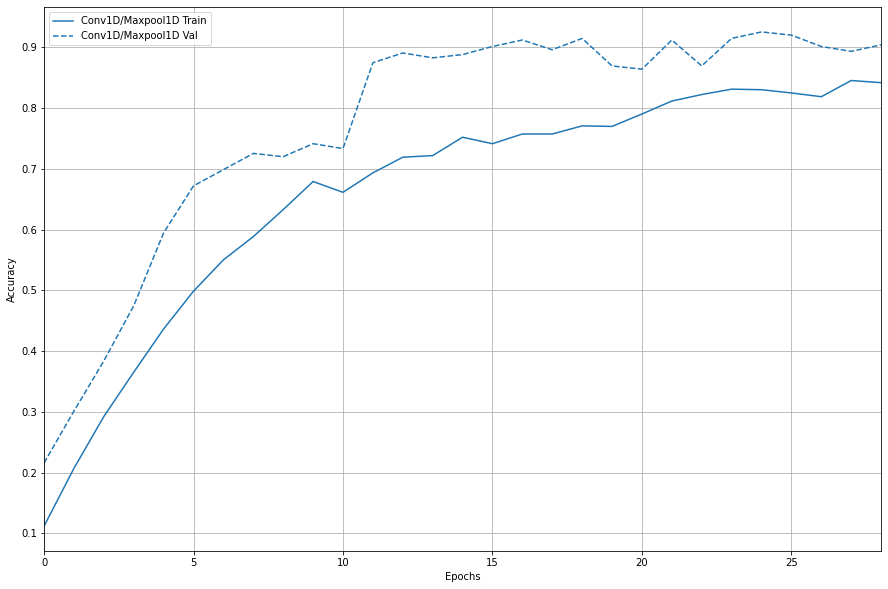

In [15]:
acc_plotter = tfplots.HistoryPlotter(metric='accuracy', smoothing_std=0)

histories = {
    'Conv1D/MaxPool1D': history
}

plt.figure(figsize=(15, 10))
acc_plotter.plot(histories)

In [16]:
y_predicted = model.predict(X_test)

scores = {}
scores['Accuracy'] = accuracy_score(y_test.argmax(axis=-1), y_predicted.argmax(axis=1))
scores['Precision'] = precision_score(y_test.argmax(axis=-1), y_predicted.argmax(axis=1), average='macro')
scores['Recall'] = recall_score(y_test.argmax(axis=-1), y_predicted.argmax(axis=1), average='macro')
scores['F1'] = f1_score(y_test.argmax(axis=-1), y_predicted.argmax(axis=1), average='macro')

display_table_dict(scores)

Accuracy,Precision,Recall,F1
0.8166666666666667,0.8506388063926359,0.8166666666666668,0.8032921544762402


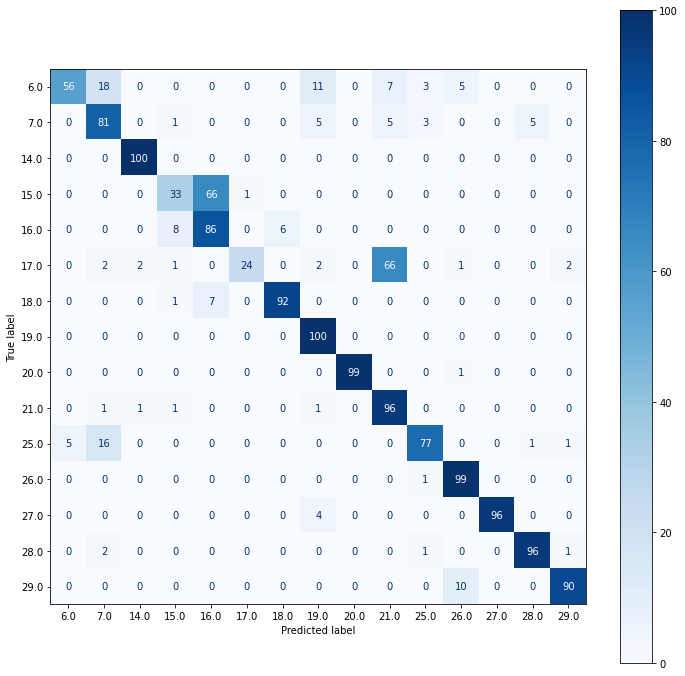

In [17]:
plot_confusion_matrix(y_test, y_predicted, labels=y_test_indexes.keys())